In [16]:
import numpy as np
import networkx as nx
from itertools import product
import numba as nb
import copy
import matplotlib.pyplot as plt
from scipy import optimize

# Trotterized Quantum Annealing Initialization for the QAOA

下面我们提供了 Trotterized Quantum Annealing (TQA) 初始化的简要教程 QAOA。初始化允许规避局部次优最优的收敛并实现 与最佳性能类似 2^p
 随机初始化

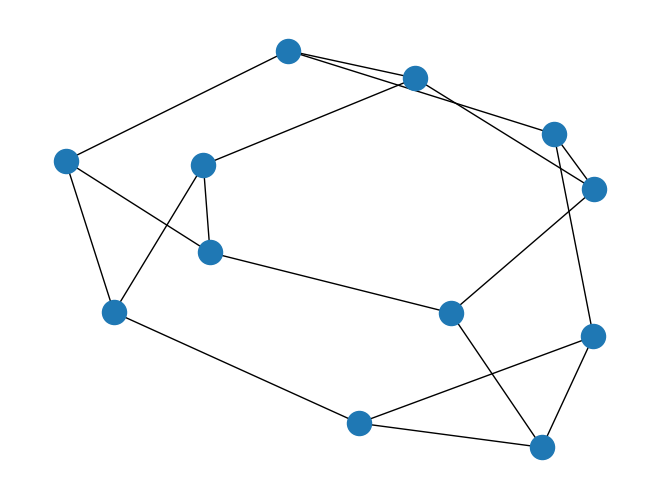

In [17]:
# Set everything up and show the graph
N = 12
seed = 42
# 生成一个 12 节点的随机规则图，每个节点的度数为3
G = nx.random_regular_graph(d=3, n=N, seed=seed)
# 获取图的边
edges_betweenness = nx.edge_betweenness_centrality(G)
edges = edges_betweenness.keys()
# 获取图的节点
nodes = G.nodes
# 绘制图
nx.draw(G)
# 创建初始态，均匀叠加态
initial_state = np.ones(2 ** N) / np.sqrt(2) ** N

# 使用 Hamiltonian 创建了一个包含所有可能自旋配置的希尔伯特空间，这里每个自旋配置由1和-1表示
H = np.array(list(product([1, -1], repeat=N))) 

In [18]:
# Fast Hadamard transformation

@nb.njit # Just in time compilation for massive speed-up
def fwht(a):
    h = 1
    tmp = a.copy()
    while 2 * h <= len(a):
        for i in range(0, len(a) - 1, h * 2):
            for j in range(i, i + h):
                x = tmp[j]
                y = tmp[j + h]
                tmp[j] = x + y
                tmp[j + h] = x - y
        h *= 2
    return tmp

def ifwht(a):
    return fwht(a) / len(a)

In [19]:
# Classical Hamiltonian, the ground state is the MaxCut solution
# we use the QAOA to find an approximation to the ground state variationally
def H_C():
    # 创建一个长度为2^N的零向量，用于存储哈密顿量的值
    tmp = np.zeros(2**N)
    for i, j in edges:
        tmp += H[:, i] * H[:, j]
    return tmp

In [20]:
# Quantum Hamiltonian, the ground state is an equal superposition of all solutions, i.e. all possible graph cuts
def H_B():
    tmp = np.zeros(2**N)
    for i in nodes:
        # 将节点 i 对应的自旋态加入到哈密顿量 tmp 中
        tmp += H[:, i]
    return tmp

In [21]:
def qaoa_state(x):

    # 构建 QAOA 的Ansatz态,利用快速沃尔什-阿达马变换（FWHT）来加速计算。
    # 使用快速阿达马变换(n log(n))来保持算符对角形式
    # 使用向量-向量乘法，而非矩阵-向量乘法，否则对于哈密顿量H_B的矩阵指数操作会非常慢
    # 将输入参数 x 分成相同长度的两部分
    beta, gamma = np.split(x, 2)
    # 复制初始态 initial_state，这个状态通常是均匀叠加态
    state = copy.copy(initial_state)

    for g, b in zip(gamma, beta):
        # 应用与问题哈密顿量 H_C 相关的相移
        state = np.exp(1j * g * H_C()) * state

        state = fwht(state)              # 使用快速沃尔什-阿达马变换（FWHT）将量子态转换到对角基
        # 在对角基中，应用混合器哈密顿量 H_B相关的相移
        state = np.exp(-1j * b * H_B()) * state
        state = ifwht(state)             # 逆快速沃尔什-阿达马变换将量子态转换回原来的基

    return state

In [22]:
# 用于计算在给定量子态下哈密顿量 h_c的期望值
def energy_expectation_value(state):
    return np.real(np.vdot(state, H_C() * state))

# Find the optimal Trotter time step

In [23]:
# 循环演化时间的不同值
time = np.linspace(0.1, 20, 100)

energies = []
for p in [3, 4]:
    energy = []
    for t_max in time: 
        
        dt = t_max / p
        t = dt * (np.arange(1, p + 1) - 0.5)
        gamma = (t / t_max) * dt
        beta = (1 - (t / t_max)) * dt
        x = np.concatenate((beta, gamma))
        energy.append(energy_expectation_value(qaoa_state(x)))

    energies.append(energy)

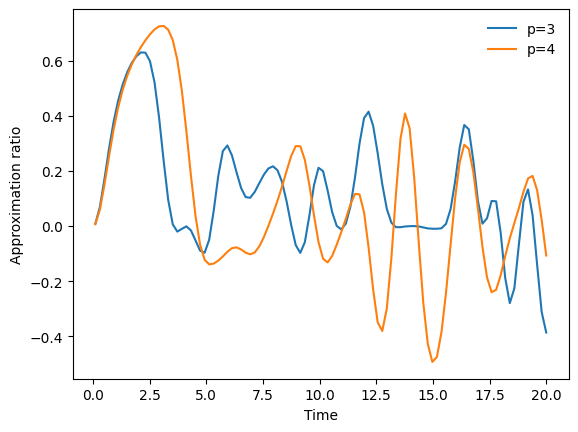

In [24]:
plt.plot(time, energies[0]/min(H_C()), label="p=3")
plt.plot(time, energies[1]/min(H_C()), label="p=4")
plt.xlabel('Time')
plt.ylabel('Approximation ratio')
plt.legend(frameon=False)

In [10]:
# # 找到能量期望值最小的时间索引
idx = np.argmin(energies[1])
# 使用该索引来确定最优的演化时间
t_max = time[idx]
# 输出最优演化时间及其对应的近似比
print(f'Optimal evolution time is {t_max} with an approximation ratio of {energies[1][idx]/min(H_C())}')

Optimal evolution time is 2.973684210526316 with an approximation ratio of 0.7270489057175233


# Launch QAOA from TQA initialization

In [11]:
# Fix initial beta and gamma values
p = 4
dt = t_max / p
t = dt * (np.arange(1, p + 1) - 0.5)
gamma = (t / t_max) * dt
beta = (1 - (t / t_max)) * dt
x0 = np.concatenate((beta, gamma))

In [12]:
func_to_optimize = lambda x: energy_expectation_value(qaoa_state(x))
result_tqa = optimize.minimize(func_to_optimize, x0, method='BFGS')

In [13]:
print(f'Final approximation ratio from TQA init. is {result_tqa.fun/min(H_C())}')

Final approximation ratio from TQA init. is 0.8216494294484988


In [14]:
# Quick comparison with a single QAOA run lauched from a random initialization
x0_random = np.concatenate((np.random.uniform(-np.pi/4, np.pi/4, p), np.random.uniform(-np.pi/2, np.pi/2, p)))
result_rand = optimize.minimize(func_to_optimize, x0_random, method='BFGS')

In [15]:
print(f'Final approximation ratio from random init. is {result_rand.fun/min(H_C())}')

Final approximation ratio from random init. is 0.7227967068926329


For a thorough performance comparison between random and TQA initialization, check out the paper.